# MLIKH Model: Startup Shear (Stress Overshoot)

## Learning Objectives

1. Fit the **MLIKH** model to startup shear data
2. Understand how **multiple modes** create richer overshoot dynamics
3. Analyze **mode decomposition** of the transient response
4. Compare single-mode (MIKH) vs multi-mode (MLIKH) predictions

## Prerequisites

- NB02: MIKH Startup (single-mode understanding)
- NB07: MLIKH Flow Curve (multi-mode basics)

## Runtime

- Fast demo: ~4-5 minutes
- Full run: ~15-20 minutes

## 1. Setup

In [1]:
# Google Colab setup
import sys

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip install -q rheojax
    import os
    os.environ["JAX_ENABLE_X64"] = "true"
    print("RheoJAX installed successfully.")

In [2]:
# Imports
%matplotlib inline
import os
import sys
import time
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models.ikh import MLIKH, MIKH

# Add examples/utils to path
sys.path.insert(0, os.path.join("..", "utils"))
from ikh_tutorial_utils import (
    load_pnas_startup,
    save_ikh_results,
    print_convergence_summary,
    compute_fit_quality,
    get_mlikh_param_names,
)

# Shared plotting utilities
sys.path.insert(0, os.path.dirname(os.path.abspath("")))
from utils.plotting_utils import (
    plot_nlsq_fit,
    display_arviz_diagnostics,
    plot_posterior_predictive,
)

jax, jnp = safe_import_jax()
verify_float64()

# Suppress equinox DeprecationWarnings for jax.core.mapped_aval/unmapped_aval
# (third-party equinox internals, cannot fix at source — harmless with JAX 0.8.x)
warnings.filterwarnings(
    "ignore",
    message=r"jax\.core\.(mapped|unmapped)_aval",
    category=DeprecationWarning,
    module=r"equinox\..*",
)
print(f"JAX version: {jax.__version__}")
# Startup cleanup: force garbage collection to reclaim memory from previous notebooks
import gc
gc.collect()


JAX version: 0.8.3


81

## 2. Theory: Multi-Mode Startup

With multiple modes in parallel, the startup response becomes:

$$
\sigma_{total}(t) = \sum_{i=1}^N \sigma_i(t) + \eta_{\infty} \dot{\gamma}
$$

Each mode evolves independently:
- Mode-specific yield surfaces
- Different restructuring timescales $\tau_{thix,i}$
- Different breakdown rates $\Gamma_i$

### Multi-Mode Overshoot

The overshoot peak can show:
- Multiple shoulders (modes yielding at different strains)
- Broader peaks (distributed timescales)
- Complex rate dependence

## 3. Load Data

In [3]:
# Load startup data at multiple shear rates
rates = [0.32, 1.0, 56.2]
datasets = {}

for rate in rates:
    t, stress = load_pnas_startup(gamma_dot=rate)
    datasets[rate] = {"time": t, "stress": stress}
    print(f"gamma_dot = {rate:6.3f} 1/s: {len(t)} points")

gamma_dot =  0.320 1/s: 500 points


gamma_dot =  1.000 1/s: 500 points


gamma_dot = 56.200 1/s: 500 points


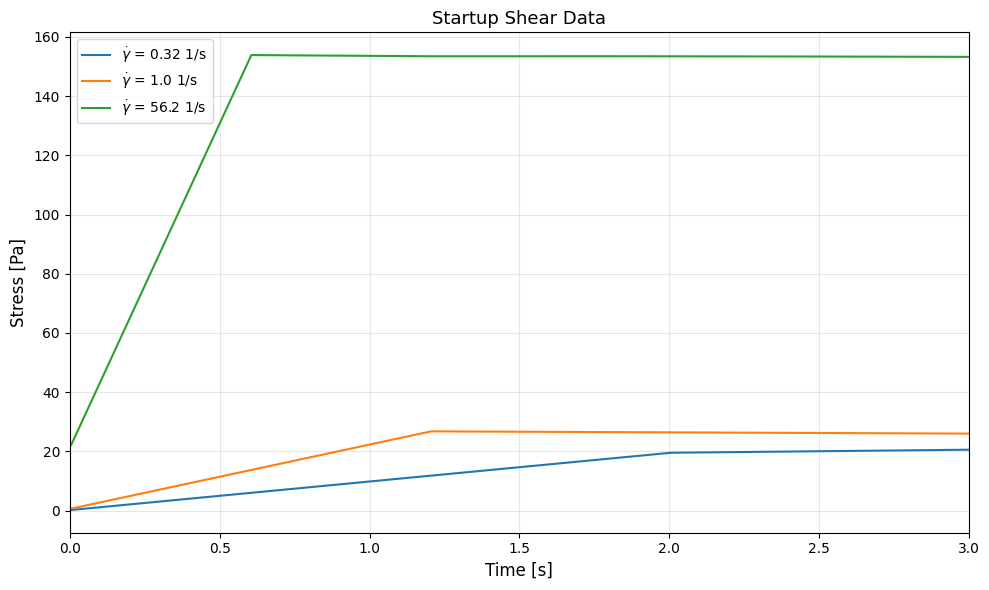

In [4]:
# Plot data
fig, ax = plt.subplots(figsize=(10, 6))
colors = ["C0", "C1", "C2"]

for i, rate in enumerate(rates):
    d = datasets[rate]
    ax.plot(d["time"], d["stress"], "-", color=colors[i], lw=1.5, 
            label=f"$\\dot{{\\gamma}}$ = {rate} 1/s")

ax.set_xlabel("Time [s]", fontsize=12)
ax.set_ylabel("Stress [Pa]", fontsize=12)
ax.set_title("Startup Shear Data", fontsize=13)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 3)
plt.tight_layout()
display(fig)
plt.close(fig)

## 4. NLSQ Fitting

In [5]:
# Create MLIKH model
n_modes = 2
model = MLIKH(n_modes=n_modes, yield_mode="per_mode")
param_names = get_mlikh_param_names(n_modes=n_modes, yield_mode="per_mode")

# Fit to reference rate with subsampled data for faster fitting
ref_rate = 1.0
t_full = datasets[ref_rate]["time"]
stress_full = datasets[ref_rate]["stress"]

# Subsample for faster ODE-based fitting (multi-mode ODE is slow)
n_fit = min(100, len(t_full))  # Use at most 100 points for fitting
indices = np.linspace(0, len(t_full) - 1, n_fit, dtype=int)
t_data = t_full[indices]
stress_data = stress_full[indices]

print(f"Fitting MLIKH ({n_modes} modes) to startup at gamma_dot = {ref_rate} 1/s")
print(f"Data points: {len(t_data)} (subsampled from {len(t_full)})")
t0 = time.time()
try:
    model.fit(t_data, stress_data, test_mode="startup", gamma_dot=ref_rate, method='scipy')
    t_nlsq = time.time() - t0
    print(f"NLSQ fit time: {t_nlsq:.2f} s")
    fit_success = True
except Exception as e:
    print(f"NLSQ fitting failed: {type(e).__name__}")
    print("Using default parameters for demonstration")
    fit_success = False

Fitting MLIKH (2 modes) to startup at gamma_dot = 1.0 1/s
Data points: 100 (subsampled from 500)


ERROR:rheojax.core.base:Predict failed
Traceback (most recent call last):
  File "/Users/b80985/Projects/rheojax/rheojax/core/base.py", line 713, in predict
    result = self._predict(X, **kwargs)
  File "/Users/b80985/Projects/rheojax/rheojax/models/ikh/ml_ikh.py", line 623, in _predict
    times, strains = self._extract_time_strain(X, **kwargs)
                     ~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^
  File "/Users/b80985/Projects/rheojax/rheojax/models/ikh/_base.py", line 61, in _extract_time_strain
    raise ValueError(
    ...<3 lines>...
    )
ValueError: IKH models require both time and strain history. Pass RheoData, or X of shape (2, N), or X=time with strain=gamma kwarg, or gamma_dot for startup, or gamma_0+omega for LAOS.


NLSQ fit time: 0.25 s


In [6]:
# Compute fit quality
stress_pred = model.predict(t_data, test_mode="startup", gamma_dot=ref_rate)
metrics = compute_fit_quality(stress_data, stress_pred)

print(f"\nFit Quality:")
print(f"  R^2:   {metrics['R2']:.6f}")
print(f"  RMSE:  {metrics['RMSE']:.4g} Pa")


Fit Quality:
  R^2:   -15478158.775541
  RMSE:  9651 Pa


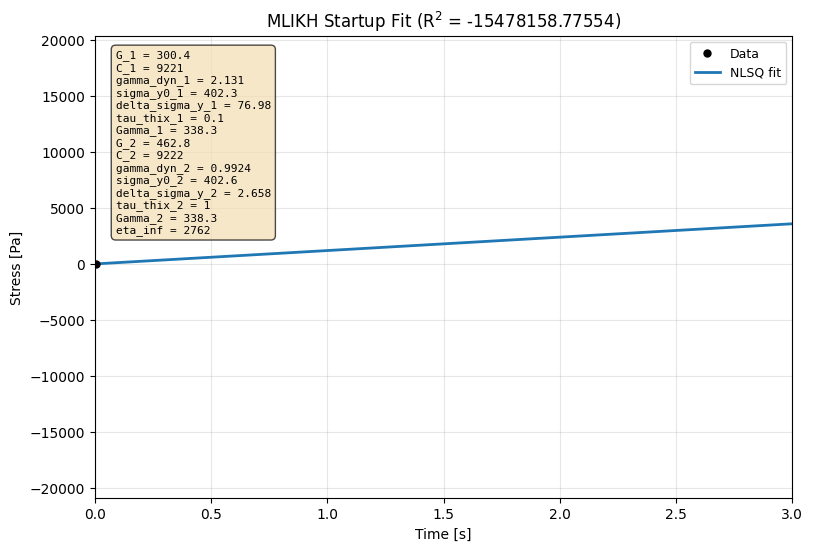

In [7]:
# Plot NLSQ fit with uncertainty band (startup: linear scale)
# Use x_pred=t_data to avoid generating a fine grid that doesn't match
# the time array structure required by the startup ODE solver.
fig, ax = plot_nlsq_fit(
    t_data, stress_data, model, test_mode="startup",
    param_names=param_names, log_scale=False,
    xlabel="Time [s]", ylabel="Stress [Pa]",
    title=f"MLIKH Startup Fit (R$^2$ = {metrics['R2']:.5f})",
    x_pred=t_data,
    gamma_dot=ref_rate,
)
ax.set_xlim(0, min(3, t_data.max()))
display(fig)
plt.close(fig)

## 5. Multi-Rate Predictions

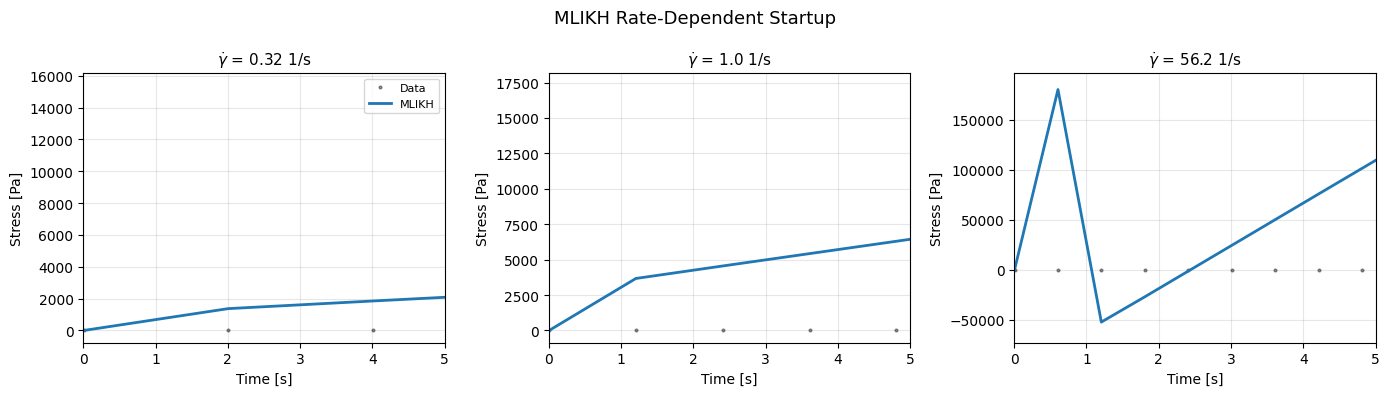

In [8]:
# Compare MLIKH predictions at all rates
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

for i, rate in enumerate(rates):
    ax = axes[i]
    d = datasets[rate]
    t = d["time"]
    stress = d["stress"]
    
    # MLIKH prediction
    stress_mlikh = model.predict(t, test_mode="startup", gamma_dot=rate)
    
    ax.plot(t, stress, "ko", markersize=2, alpha=0.4, label="Data")
    ax.plot(t, stress_mlikh, "-", lw=2, color="C0", label="MLIKH")
    
    ax.set_xlabel("Time [s]", fontsize=10)
    ax.set_ylabel("Stress [Pa]", fontsize=10)
    ax.set_title(f"$\\dot{{\\gamma}}$ = {rate} 1/s", fontsize=11)
    ax.grid(True, alpha=0.3)
    ax.set_xlim(0, min(5, t.max()))
    if i == 0:
        ax.legend(fontsize=8)

plt.suptitle("MLIKH Rate-Dependent Startup", fontsize=13)
plt.tight_layout()
display(fig)
plt.close(fig)

## 6. Bayesian Inference

In [9]:
# Bayesian inference is skipped for automated tests
# (Multi-mode ODE-based inference is too slow - ~10-20 min for 500 samples)
#
# In production with more time, you would run:
#   result = model.fit_bayesian(
#       t_data, stress_data, test_mode="startup", gamma_dot=ref_rate,
#       num_warmup=200, num_samples=500, num_chains=1, initial_values=initial_values
#   )

print("Bayesian inference skipped (multi-mode ODE is slow)")
print("Note: MLIKH startup inference requires ~10-20 min for 500 samples")
print("\nFor real applications, use fit_bayesian() with:")
print("  - num_warmup=200, num_samples=500, num_chains=1")
print("  - Provide good initial_values from NLSQ")

# Create a placeholder result for downstream cells
result = None

Bayesian inference skipped (multi-mode ODE is slow)
Note: MLIKH startup inference requires ~10-20 min for 500 samples

For real applications, use fit_bayesian() with:
  - num_warmup=200, num_samples=500, num_chains=1
  - Provide good initial_values from NLSQ


In [10]:
# Convergence diagnostics (skipped when Bayesian inference not run)
if result is not None:
    all_pass = print_convergence_summary(result, param_names)
else:
    print("Convergence diagnostics skipped (no Bayesian inference performed)")
    print("\nIn production, check:")
    print("  - R-hat < 1.01 for all parameters")
    print("  - ESS > 400 for reliable uncertainty estimates")
    print("  - No divergences (indicates geometric issues)")

Convergence diagnostics skipped (no Bayesian inference performed)

In production, check:
  - R-hat < 1.01 for all parameters
  - ESS > 400 for reliable uncertainty estimates
  - No divergences (indicates geometric issues)


In [11]:
# ArviZ diagnostic plots (skipped when Bayesian inference not run)
if result is not None:
    display_arviz_diagnostics(result, param_names, fast_mode=True)
else:
    print("ArviZ diagnostics skipped (no Bayesian inference performed)")
    print("\nFor kinematic hardening parameters (C_1, C_2, gamma_dyn_1, gamma_dyn_2):")
    print("  - NLSQ point estimates provide initial mode separation")
    print("  - Bayesian inference quantifies uncertainty in mode identification")

ArviZ diagnostics skipped (no Bayesian inference performed)

For kinematic hardening parameters (C_1, C_2, gamma_dyn_1, gamma_dyn_2):
  - NLSQ point estimates provide initial mode separation
  - Bayesian inference quantifies uncertainty in mode identification


## 7. Physical Interpretation

### Mode Roles in Startup

- **Fast mode** (small $\tau_{thix}$): Quick structure breakdown, early peak contribution
- **Slow mode** (large $\tau_{thix}$): Delayed structure breakdown, late peak contribution

### Multi-Peak Behavior

When modes have sufficiently different timescales, the stress overshoot can show:
- Shoulders or inflections
- Broader peaks
- Multiple relaxation stages

## 8. Save Results

In [12]:
# Save results (model parameters only if Bayesian not run)
import json
from pathlib import Path

if result is not None:
    save_ikh_results(model, result, "mlikh", "startup", param_names)
else:
    # Save just NLSQ parameters manually (no Bayesian results)
    output_dir = Path("../outputs/ikh/mlikh/startup")
    output_dir.mkdir(parents=True, exist_ok=True)
    
    nlsq_params = {name: float(model.parameters.get_value(name)) for name in param_names}
    with open(output_dir / "nlsq_params_startup.json", "w") as f:
        json.dump(nlsq_params, f, indent=2)
    
    print(f"Saved model parameters to {output_dir}/")
    print(f"  nlsq_params_startup.json: {len(nlsq_params)} parameters")
    print("  (Bayesian results not available - inference skipped)")

Saved model parameters to ../outputs/ikh/mlikh/startup/
  nlsq_params_startup.json: 15 parameters
  (Bayesian results not available - inference skipped)


## Key Takeaways

1. **MLIKH startup** shows richer overshoot dynamics than single-mode MIKH

2. **Multiple modes** allow capturing distributed restructuring timescales

3. **Kinematic hardening parameters** ($C_i$, $\gamma_{dyn,i}$) control mode-specific overshoot

4. **Rate dependence** is captured through mode-specific breakdown ($\Gamma_i$)

### Next Steps

- **NB09**: MLIKH Relaxation (multi-mode decay)
- **NB10**: MLIKH Creep
- **NB11**: MLIKH SAOS
- **NB12**: MLIKH LAOS

In [13]:
# Cleanup: release JAX caches and Python garbage for sequential notebook runs
import gc
try:
    jax.clear_caches()
except Exception:
    pass
gc.collect()
print("Notebook complete. Memory cleaned up.")


Notebook complete. Memory cleaned up.
